# Installs

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Comment this to use gpu

In [3]:
!pip install pytorch-lightning
!pip install torch-geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install jax
!pip install --upgrade jax jaxlib==0.4.20+cpu -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install tensorcircuit
!pip install qiskit
!pip install matplotlib
!pip install pylatexenc
!pip install tabulate
!pip install kmapper
!pip install qutip

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
ERROR: Ignored the following yanked versions: 0.4.32
ERROR: Could not find a version that satisfies the requirement jaxlib==0.4.20+cpu (from versions: 0.1.75+cuda11.cudnn805, 0.1.75+cuda11.cudnn82, 0.1.76+cuda11.cudnn805, 0.1.76+cuda11.cudnn82, 0.3.0+cuda11.cudnn805, 0.3.0+cuda11.cudnn82, 0.3.2+cuda11.cudnn805, 0.3.2+cuda11.cudnn82, 0.3.5+cuda11.cudnn805, 0.3.5+cuda11.cudnn82, 0.3.7+cuda11.cudnn805, 0.3.7+cuda11.cudnn82, 0.3.8+cuda11.cudnn805, 0.3.8+cuda11.cudnn82, 0.3.10+cuda11.cudnn805, 0.3.10+cuda11.cudnn82, 0.3.14+cuda11.cudnn805, 0.3.14+cuda11.cudnn82, 0.3.15+cuda11.cudnn805, 0.3.15+cuda11.cudnn82, 0.3.18+cuda11.cudnn805, 0.3.18+cuda11.cudnn82, 0.3.20+cuda11.cudnn805, 0.3.20+cuda11.cudnn82, 0.3.22+cuda11.cudnn805, 0.3.22+cuda11.cudnn82, 0.3.24+cuda11.cudnn805, 0.3.24+cuda11

In [4]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.transforms as T

import torch
import torch.nn as nn
import qutip
from qutip import Bloch
import matplotlib
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelSummary
from pytorch_lightning.callbacks import Callback

from pytorch_lightning.loggers import WandbLogger

import jax
import jax.numpy as jnp
import tensorcircuit as tc

import numpy as np
import pandas as pd
import kmapper as km
import networkx as nx
from copy import copy

import warnings
warnings.filterwarnings('ignore')

torch.set_float32_matmul_precision("medium")
K = tc.set_backend("jax")
print(tc.__version__)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importin

0.12.0


In [5]:
jax.devices()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


# QUANTUM MODEL


In [6]:
def get_circ(nqubits, nlayers, x, weights):

    c = tc.Circuit(nqubits)
    for i in range(nqubits):
        c.rx(i, theta=x[i])
    for j in range(nlayers):
        for i in range(nqubits - 1):
            c.cnot(i, i + 1)
        for i in range(nqubits):
            c.rx(i, theta=weights[2 * j, i])
            c.ry(i, theta=weights[2 * j + 1, i])
    return c

In [7]:
def circuit_wrapper(nqubits, nlayers):
    def qpred(x, weights):
        circuit = get_circ(nqubits, nlayers, x, weights)
        return K.real(jnp.array([circuit.expectation_ps(z=[i]) for i in range(nqubits)]))

    qpred_vmap = K.vmap(qpred, vectorized_argnums=0)
    qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True)

    return qpred_batch

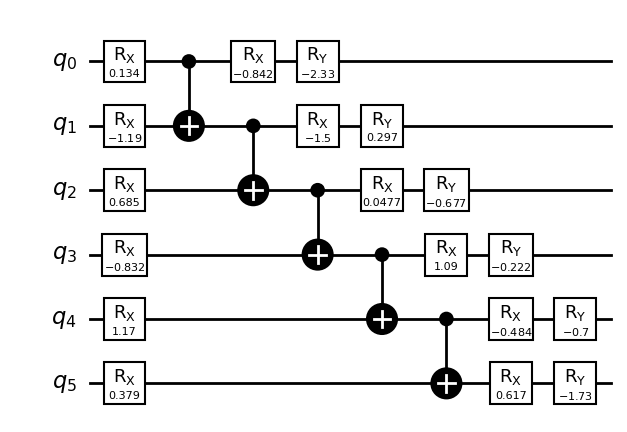

In [8]:
# Test the AD capacity of the PyTorch function
nqubits = 6
nlayers = 1
w = torch.randn([2 * nlayers, nqubits])
dummy_x = torch.randn([3, nqubits])

fig = get_circ(nqubits, nlayers, dummy_x[0], w).draw(output='mpl', style="bw", fold=0)
fig

In [9]:
qpred_batch = circuit_wrapper(nqubits, nlayers)

In [10]:
w.requires_grad_()
with torch.set_grad_enabled(True):
    print(dummy_x.shape, dummy_x)
    yps = qpred_batch(dummy_x, w)
    loss = torch.sum(yps)
    loss.backward()
print(w.grad, yps)

torch.Size([3, 6]) tensor([[ 0.1345, -1.1878,  0.6852, -0.8316,  1.1749,  0.3787],
        [-0.0664, -0.8134,  0.1594,  1.0238, -0.0235, -0.6374],
        [ 0.4280, -0.3296,  1.2782,  0.4208,  1.4374, -0.2086]])
tensor([[-1.4931,  1.8287, -0.0451, -0.6661,  0.1624,  0.0109],
        [ 1.3961, -0.0372,  0.7582,  0.0792,  0.2604,  0.4145]]) tensor([[-0.4553,  0.0235,  0.2232,  0.0878,  0.0504, -0.0066],
        [-0.4585,  0.0435,  0.5270,  0.1601,  0.2383, -0.0571],
        [-0.4180,  0.0546,  0.1933,  0.1031,  0.0204, -0.0045]],
       grad_fn=<FunBackward>)


In [11]:
class QuantumNet(nn.Module):
    def __init__(self, nqubits, nlayers):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([2 * nlayers, nqubits]))
        self.qpred_batch = circuit_wrapper(nqubits, nlayers)

        self.nqubits = nqubits
        self.nlayers = nlayers

    def forward(self, inputs):
#         print("Inside quantum net", inputs.shape)
        ypred = self.qpred_batch(inputs, self.q_weights)
#         print("output of qpred", ypred.shape)
        return ypred

In [12]:
net = QuantumNet(6, 2)
out = net(dummy_x)
print(out)
print(out.shape)

tensor([[ 0.0208,  0.0875,  0.0664, -0.4327,  0.3413, -0.0084],
        [-0.0488,  0.2111,  0.1318, -0.6911,  0.8620,  0.3127],
        [-0.0555,  0.3459,  0.0597, -0.0608,  0.7029, -0.0987]],
       grad_fn=<FunBackward>)
torch.Size([3, 6])


In [13]:
class QGCNConv(geom_nn.GCNConv):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        improved: bool = False,
        cached: bool = False,
        add_self_loops: bool = True,
        normalize: bool = True,
        bias: bool = True,
        nlayers = 2,
        **kwargs,
    ):
        super().__init__(in_channels,
                        out_channels,
                        improved,
                        cached,
                        add_self_loops,
                        normalize,
                        bias,
                        **kwargs)
        self.lin = QuantumNet(in_channels, nlayers)

#### This part is testing the QGCNonv model

# Finance Dataset

#### Loading

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Install the Kaggle library
!pip install kaggle

# Upload kaggle.json file
from google.colab import files
files.upload()  # This will prompt you to upload kaggle.json

# Make a directory for Kaggle and move the file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Now you can download the dataset
!kaggle datasets download -d volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary -p /content/datasets --unzip

print("Dataset downloaded to: /content/datasets")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary
License(s): CC0-1.0
  0% 0.00/738k [00:00<?, ?B/s]
100% 738k/738k [00:00<00:00, 93.5MB/s]
Dataset downloaded to: /content/datasets


In [163]:
finance_df=pd.read_csv("/content/datasets/fraud_detection_bank_dataset.csv",delimiter=',')

In [164]:
finance_df.describe()

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,10233.500000,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,3.226256,0.0,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,5908.746991,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,20.564308,0.0,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5116.750000,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,10233.500000,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,15350.250000,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,2.000000,0.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,20467.000000,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,2301.000000,0.0,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


In [165]:
finance_df

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,0,9,1354,0,18,0,1,7,9,0,...,0,0,0,1,1,0,0,0,49,1
1,1,0,239,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,2,0,260,0,4,0,3,6,0,0,...,0,0,0,1,1,0,0,0,56,1
3,3,17,682,0,1,0,0,8,17,0,...,0,1,0,1,1,0,0,0,65,1
4,4,1,540,0,2,0,1,7,1,0,...,0,0,0,1,1,0,0,0,175,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20463,20463,0,88,0,0,0,2,-1,0,0,...,0,1,0,0,0,0,1,0,85,0
20464,20464,0,134,0,2,0,0,6,0,0,...,0,0,0,0,0,0,0,0,7,0
20465,20465,4,393,1,1,0,0,-1,4,0,...,0,1,0,0,0,0,0,0,45,0
20466,20466,0,10,0,1,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,5,0


In [166]:
# Compute the full correlation matrix
corr_matrix = finance_df.corr()

# Target column
target_col = 'targets'  # Replace with your actual target column name

# Find the top correlating columns (excluding the target itself)
top_corr_cols = corr_matrix[target_col].abs().sort_values(ascending=False).index[1:10]  # Top 5 correlations

# Filter the correlation matrix for these columns
filtered_corr_matrix = corr_matrix.loc[top_corr_cols, top_corr_cols]

# Print and display the matrix
print("Correlation matrix of highest correlating columns:")
print(filtered_corr_matrix)

Correlation matrix of highest correlating columns:
            Unnamed: 0    col_83    col_76    col_86    col_74   col_104  \
Unnamed: 0    1.000000 -0.395479 -0.240981 -0.208707 -0.208898 -0.209677   
col_83       -0.395479  1.000000  0.411629  0.371083  0.167532  0.305090   
col_76       -0.240981  0.411629  1.000000  0.228474  0.136115  0.233352   
col_86       -0.208707  0.371083  0.228474  1.000000  0.051504  0.156870   
col_74       -0.208898  0.167532  0.136115  0.051504  1.000000  0.151922   
col_104      -0.209677  0.305090  0.233352  0.156870  0.151922  1.000000   
col_85       -0.206467  0.387926  0.245564  0.304171  0.031258  0.155757   
col_14        0.203971 -0.201067 -0.069783 -0.107645 -0.052160 -0.057616   
col_106       0.199142 -0.131351  0.046256 -0.084935 -0.039631  0.004313   

              col_85    col_14   col_106  
Unnamed: 0 -0.206467  0.203971  0.199142  
col_83      0.387926 -0.201067 -0.131351  
col_76      0.245564 -0.069783  0.046256  
col_86      0.30

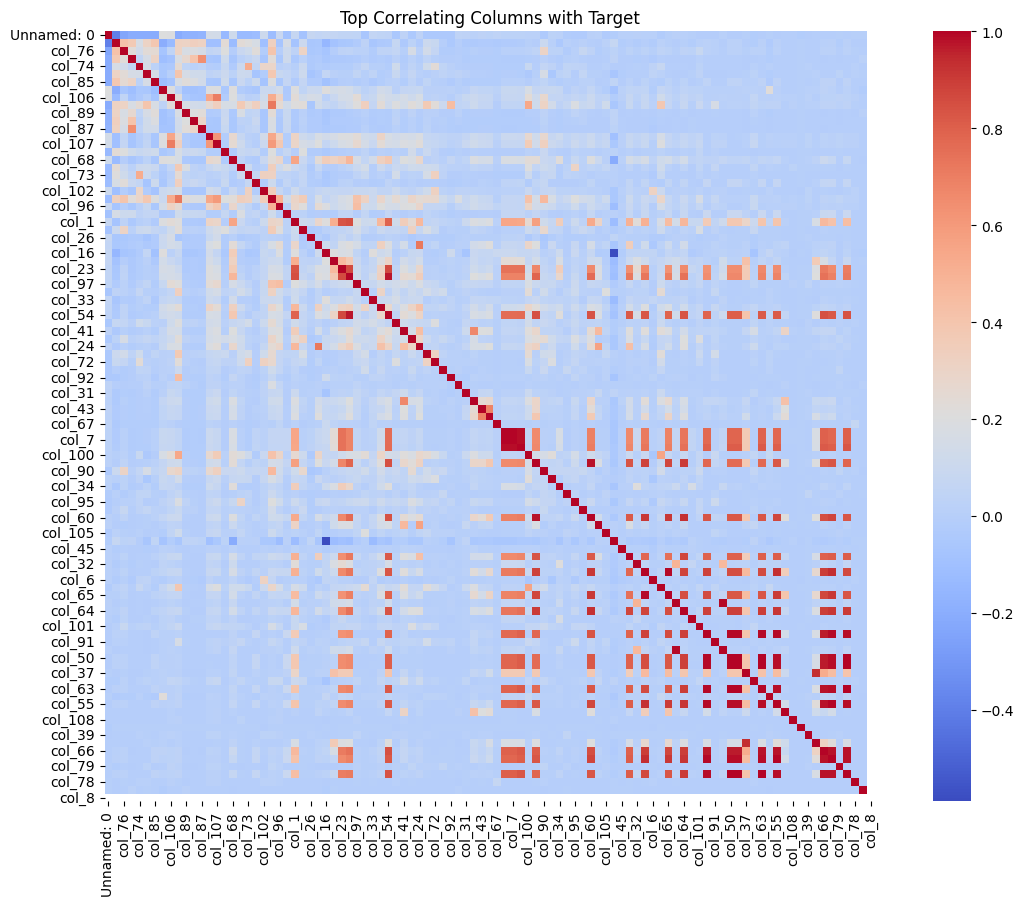

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the full correlation matrix
corr_matrix = finance_df.corr()

# Target column
target_col = 'targets'  # Replace with your actual target column name

# Find the top correlating columns (excluding the target itself)
top_corr_cols = corr_matrix[target_col].abs().sort_values(ascending=False).index[1:100]  # Top 5 correlations

# Filter the correlation matrix for these columns
filtered_corr_matrix = corr_matrix.loc[top_corr_cols, top_corr_cols]

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(filtered_corr_matrix, annot=False, cmap="coolwarm", fmt=".2f", cbar=True, square=True)
plt.title("Top Correlating Columns with Target")
plt.show()


In [218]:
zeros_df = finance_df[finance_df[target_col] == 0]
ones_df = finance_df[finance_df[target_col] == 1]

# Calculate the number of samples to keep for each class
sample_size_zeros = len(zeros_df) // 10
sample_size_ones = len(ones_df) // 10

sampled_zeros_df = zeros_df.sample(n=sample_size_zeros, random_state=42)  # Use random_state for reproducibility
sampled_ones_df = ones_df.sample(n=sample_size_ones, random_state=42)

# Concatenate the sampled subsets
sampled_finance_df = pd.concat([sampled_zeros_df, sampled_ones_df])

# Shuffle the sampled DataFrame to mix the classes
sampled_finance_df = sampled_finance_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset shape: {finance_df.shape}")
print(f"Sampled dataset shape: {sampled_finance_df.shape}")
print(f"Original 0/1 ratio: {finance_df[target_col].value_counts(normalize=True)}")
print(f"Sampled 0/1 ratio: {sampled_finance_df[target_col].value_counts(normalize=True)}")

finance_df = sampled_finance_df # Replace the original with the sampled dataframe

Original dataset shape: (20468, 114)
Sampled dataset shape: (2046, 114)
Original 0/1 ratio: targets
0    0.734317
1    0.265683
Name: proportion, dtype: float64
Sampled 0/1 ratio: targets
0    0.734604
1    0.265396
Name: proportion, dtype: float64


In [222]:
sampled_finance_df

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,10643,0,263,0,2,0,0,7,0,0,...,0,0,0,0,0,0,0,0,112,0
1,18933,2,228,0,2,0,0,0,2,0,...,0,0,0,1,0,0,0,0,5,0
2,18097,8,352,0,0,0,3,2,8,0,...,0,1,0,1,0,0,0,0,71,0
3,19200,56,1178,0,1,0,0,-1,56,0,...,0,0,0,0,0,0,0,0,0,0
4,1503,19,730,0,3,0,1,0,19,0,...,0,0,0,1,1,0,1,0,91,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,13452,0,221,0,4,0,0,7,0,0,...,0,0,0,0,0,0,0,0,8,0
2042,17112,3,209,0,2,0,0,6,3,0,...,0,0,0,0,0,0,0,0,7,0
2043,12523,0,106,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2044,7578,6,679,0,1,0,5,0,6,0,...,0,0,0,1,1,0,1,0,164,0


In [223]:
finance_df

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,10643,0,263,0,2,0,0,7,0,0,...,0,0,0,0,0,0,0,0,112,0
1,18933,2,228,0,2,0,0,0,2,0,...,0,0,0,1,0,0,0,0,5,0
2,18097,8,352,0,0,0,3,2,8,0,...,0,1,0,1,0,0,0,0,71,0
3,19200,56,1178,0,1,0,0,-1,56,0,...,0,0,0,0,0,0,0,0,0,0
4,1503,19,730,0,3,0,1,0,19,0,...,0,0,0,1,1,0,1,0,91,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,13452,0,221,0,4,0,0,7,0,0,...,0,0,0,0,0,0,0,0,8,0
2042,17112,3,209,0,2,0,0,6,3,0,...,0,0,0,0,0,0,0,0,7,0
2043,12523,0,106,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2044,7578,6,679,0,1,0,5,0,6,0,...,0,0,0,1,1,0,1,0,164,0


In [224]:
import pandas as pd

# Compute the correlation matrix
correlation_matrix = finance_df.corr()

# Extract the correlations of all features with the target column
correlations_with_target = correlation_matrix['targets'].drop('targets')

# Select the top 15 features with the highest absolute correlation values
top_15_features_with_corr = correlations_with_target.abs().sort_values(ascending=False).head(15)

# Keep only the top 15 features along with the target column
top_15_features = top_15_features_with_corr.index.tolist()
finance_df_top_features_corr = finance_df[top_15_features + ['targets']]

In [225]:
top_15_features_with_corr

,targets
Unnamed: 0,0.769708
col_83,0.549430
col_76,0.324168
col_111,0.296553
col_14,0.283436
col_104,0.277262
col_85,0.273527
col_74,0.265618
col_86,0.258739
col_84,0.256151


In [227]:
finance_df_top_features_corr

,Unnamed: 0,col_83,col_76,col_111,col_14,col_104,col_85,col_74,col_86,col_84,col_106,col_89,col_87,col_98,col_109,targets
0,10643,0,0,112,0,0,0,0,0,0,0,0,0,0,0,0
1,18933,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0
2,18097,0,0,71,1,1,0,0,0,0,1,0,0,0,0,0
3,19200,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1503,1,0,91,0,0,0,1,0,0,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,13452,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0
2042,17112,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0
2043,12523,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2044,7578,0,0,164,1,0,0,0,0,0,1,0,0,1,1,0


In [228]:
final_df=finance_df_top_features_corr

### Preparing

In [190]:
def get_graph(nx_graph, data, row):
  nodes = list(nx_graph.nodes());
  edges = list(nx_graph.edges());
  feature = [];
  for n in nodes:
    mem = np.array(nx_graph._node[n]['membership']);
    id = np.zeros(14, dtype = int);
    id[mem] = 1;
    ft = data * id;
    feature.append(ft)
  edges = np.array(list(map(lambda x: (nodes.index(x[0]), nodes.index(x[1])),edges)))
  nodes = np.array(list(map(lambda x: nodes.index(x),nodes)))
  return nodes, edges.transpose(), np.array(feature);

In [191]:
mp = km.KeplerMapper()
transform = T.Compose([T.Pad(max_num_nodes=16, max_num_edges=5, mask_pad_value=True)])

def get_data(df):

    data_list = []
    # List to store processed graph data objects.

    nodes_dist, edges_dist = [], []
    # Lists to track node and edge distributions for each graph.

    graphs = []
    # List to store graph structures for further use.

    for i in range(df.shape[0]):
        data_row = df.loc[i, df.columns[1:15]].to_numpy()
        # Extracts specific columns as features for each row.

        data = data_row.transpose()
        # Transposes features to match the input shape for KeplerMapper.

        Y = df.iloc[i, 15]
        # Extracts target label for the row.

        amt = df.iloc[i, 1]
        # Extracts the 'amount' feature for each row.

        time = df.iloc[i, 0]
        # Extracts the 'time' feature for each row.

        amt = np.repeat(amt, data.shape[0])
        # Repeats the amount value for all data points in the row.

        time = np.repeat(time, data.shape[0])
        # Repeats the time value for all data points in the row.

        data = np.stack((data, amt, time), axis=1)
        # Stacks the features, amount, and time into a single array.

        lens = mp.project(data)
        # Projects data into a lower-dimensional lens for mapping.

        graph = mp.map(X=data, lens=lens)
        # Creates a topological graph representation of the data.

        nx_graph = km.adapter.to_nx(graph)
        # Converts the mapper's graph structure into a NetworkX graph.

        nodes, edges, features = get_graph(nx_graph, data_row, i)
        # Extracts nodes, edges, and features from the graph.

        nodes_dist.append(len(nodes))
        # Appends the number of nodes in the graph.

        edges_dist.append(0 if len(edges) == 0 else edges.shape[1])
        # Appends the number of edges (or zero if no edges exist).

        data_list.append(
            geom_data.Data(
                x=torch.tensor(features, dtype=torch.float),
                # Stores node features as a PyTorch tensor.
                edge_index=torch.tensor(edges, dtype=torch.int64),
                # Stores edge indices as a PyTorch tensor.
                y=torch.tensor(Y)
                # Stores the target label as a PyTorch tensor.
            )
        )

        graphs.append((nx_graph, nodes, edges, features))
        # Stores graph structure and associated details.

    return data_list, graphs
    # Returns the processed data list and graph structures.



In [229]:
data_list, graphs = get_data(final_df)

In [230]:
data_list

[Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[2, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[2, 14], edge_index=[0], y=1),
 Data(x=[1, 14], edge_index=[0], y=1),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=1),
 Data(x=[10, 14], edge_index=[2, 45], y=1),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[2, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[2, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[2, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edge_index=[0], y=0),
 Data(x=[1, 14], edg

In [231]:
batch_s = 128;
split = int(len(data_list) * 0.75);
graph_train_loader = geom_data.DataLoader(data_list[:split], batch_size=batch_s,shuffle=True)
graph_val_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)
graph_test_loader = geom_data.DataLoader(data_list[split:], batch_size=batch_s,shuffle=False)

In [232]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y)
print("Batch indices:", batch.batch)
print("Batch ptr:", batch.ptr)

Batch: DataBatch(x=[338, 14], edge_index=[2, 855], y=[128], batch=[338], ptr=[129])
Labels: tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0])
Batch indices: tensor([  0,   1,   1,   2,   2,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   4,   5,   6,   7,   8,   9,  10,  10,  11,  11,  12,  13,  14,
         15,  16,  17,  17,  18,  18,  19,  19,  20,  21,  21,  21,  21,  21,
         21,  21,  21,  21,  21,  22,  23,  23,  24,  24,  24,  24,  24,  24,
         24,  24,  24,  24,  25,  26,  27,  27,  28,  29,  29,  29,  29,  29,
         29,  29,  29,  29,  29,  30,  31,  32,  33,  33,  33,  33,  3

#Models

In [234]:
import torch
import torch.nn as nn
import torch_geometric.nn as geom_nn  # Assumes usage of PyTorch Geometric

class GraphGNNModel(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            num_layers - Number of "hidden" quantum graph layers
            dp_rate - Dropout rate applied throughout the network
            dp_rate_linear - Dropout rate before the final linear layer
            kwargs - Additional arguments for the quantum graph layers (e.g. number of heads)
        """
        super().__init__()
        # Embedding layer
        self.embed = nn.Linear(c_in, c_hidden)
        self.dropout_embed = nn.Dropout(dp_rate)

        # Quantum Graph Layers
        self.qgnn_layers = nn.ModuleList()
        self.dropouts_qgnn = nn.ModuleList()
        in_channels = c_hidden
        for _ in range(num_layers):
            self.qgnn_layers.append(
                QGCNConv(in_channels=in_channels, out_channels=c_hidden, nlayers=2, bias=False, **kwargs)
            )
            self.dropouts_qgnn.append(nn.Dropout(dp_rate))
            in_channels = c_hidden

        # Classical Graph Convolution Layer
        self.gcn_layer = geom_nn.GCNConv(in_channels, c_hidden)

        # Final prediction head
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph
                         (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        # Embedding step
        x = self.embed(x)
        x = self.dropout_embed(x)

        # Quantum GNN processing
        for qgnn_layer, dropout in zip(self.qgnn_layers, self.dropouts_qgnn):
            x = qgnn_layer(x, edge_index)
            x = dropout(x)

        # Graph Convolution Layer
        # x = self.gcn_layer(x, edge_index)

        # Graph-level pooling
        x = geom_nn.global_mean_pool(x, batch_idx)

        # Final prediction
        x = self.head(x)

        return x


In [212]:
def get_prob(probs):
  ex = probs.exp();
  return ex / ex.sum();

class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.model = GraphGNNModel(**model_kwargs).to(device);
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()
        self.one_cycle_max_lr = 1e-1
        self.one_cycle_total_steps = 100
        self.test_prob = [];
        self.test_actual = [];

    def forward(self, tdata, mode="train"):
        data = tdata

        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float() # Positive means fraud
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        # print("After model", x, preds)

        target = data.y.cpu().numpy();
        predicton = preds.cpu().numpy();

        cm = confusion_matrix(target,predicton);
        ac = accuracy_score(target,predicton);
        ps = precision_score(target,predicton);
        rs = recall_score(target,predicton);
        fs = f1_score(target,predicton);

        # print("Values", cm)
        if mode == "test":
          return loss, acc, cm, ac, ps, rs, fs, target, get_prob(x).cpu().numpy();
        else :
          return loss, acc, cm, ac, ps, rs, fs;

    def configure_optimizers(self):
        # High lr because of small dataset and small model
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.001)
        return optimizer
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer, max_lr=self.one_cycle_max_lr, total_steps=self.one_cycle_total_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="train")
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, batch_size=batch_s)
        # print(loss)
        # print("Training called for: ", batch_idx);
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs = self.forward(batch, mode="val")
        self.log('val_acc', acc, prog_bar=True, batch_size=batch_s)
        self.log('val_loss', loss, prog_bar=True, batch_size=batch_s)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc, cm, ac, ps, rs, fs, y, x  = self.forward(batch, mode="test")
        self.log('test_acc', acc, on_step=False, on_epoch=True, batch_size=batch_s)
        # self.log('test_cm', cm.tolist(), on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ac', ac, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_ps', ps, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_rs', rs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.log('test_fs', fs, on_step=False, on_epoch=True, batch_size=batch_s)
        self.test_prob.extend(x.tolist());
        self.test_actual.extend(y.tolist());

# Trainer

In [213]:
from time import time

CHECKPOINT_PATH = "/content/checkpoints"

class MetricTracker(Callback):

  def __init__(self):
    self.collection = []

  def on_train_epoch_end(self, trainer, module):
    metric = trainer.logged_metrics.copy();
    self.collection.append(metric)
    # print("train trainer end", trainer.logged_metrics)

def disp_loss(trainer):
  # print(trainer.callbacks[2].collection)

  train_loss = list(map(lambda x: x['train_loss'].item(),
                        trainer.callbacks[2].collection));
  val_loss = list(map(lambda x: x['val_loss'].item(),
                        trainer.callbacks[2].collection));

  # print(range(len(train_loss)), train_loss)
  fig = plt.figure();
  plt.plot(range(len(train_loss)), train_loss, color = 'b', label = 'Training Loss');
  plt.plot(range(len(val_loss)),val_loss, color = 'r', label = 'Validation Loss');

  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # Adding legend, which helps us recognize the curve according to it's color
  plt.legend()
  plt.show();
  fig.savefig('Quantum_Loss.pdf', format='pdf', dpi=300, bbox_inches='tight');


In [214]:
import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, ModelSummary, LearningRateMonitor
from time import time

In [215]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"

!rm -rf /tmp/*


def train_graph_classifier(model_name, num_epochs=10, **model_kwargs):
    pl.seed_everything(42)

    # Setup callbacks without specifying a root directory for checkpointing
    callbacks = [
        ModelSummary(max_depth=4),
        LearningRateMonitor(logging_interval='epoch'),
        ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min"),  # Save best model by validation loss
        MetricTracker()  # Assumes MetricTracker is defined elsewhere
    ]

    # Initialize the trainer
    trainer = pl.Trainer(
        callbacks=callbacks,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        log_every_n_steps=2,
        max_epochs=num_epochs,
        enable_progress_bar=True
    )

    #########################    MODEL   #############################
    model = GraphLevelGNN(c_in=14, c_out=1, **model_kwargs).to(device)
    ##################################################################


    s = time()
    trainer.fit(model, graph_train_loader, graph_val_loader)
    e = time()

    # Display loss progression
    disp_loss(trainer)

    # Test best model on validation and test sets
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    test_y, test_prob = model.test_actual, model.test_prob
    train_result = trainer.test(model, graph_train_loader, verbose=False)

    # Collect test and train results for specific metrics
    result = [
        {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']},
        {"test": test_result[0]['test_ac'], "train": train_result[0]['test_ac']},
        {"test": test_result[0]['test_ps'], "train": train_result[0]['test_ps']},
        {"test": test_result[0]['test_rs'], "train": train_result[0]['test_rs']},
        {"test": test_result[0]['test_fs'], "train": train_result[0]['test_fs']}
    ]

    return model, result, (e - s) / num_epochs, test_y, test_prob



rm: cannot remove '/tmp/colab_runtime.sock': Device or resource busy


# Run

In [216]:
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["XLA_PTX_ASM_COMPILATION"] = "0"
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       5.1Gi       5.1Gi        21Mi       2.4Gi       7.2Gi
Swap:             0B          0B          0B


In [ ]:
# Precision - recall curve
precision, recall, thresholds = precision_recall_curve(test_y, test_prob)
auc_pr = auc(recall, precision)
fig = plt.figure();
plt.plot(recall, precision, color = 'b', label = f'PR Curve (AUC = {auc_pr:2.2f})');
plt.xlabel("Recall")
plt.ylabel("Precision")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend(loc = 'upper right')
plt.show();
fig.savefig('Quantum_PR.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [235]:
num_epochs = 15
model, result, avg_epoch_time, test_y, test_prob = train_graph_classifier(model_name="QGCN",
                                       c_hidden=6,
                                      #  layer_name="QGCN",
                                       num_layers=2,
                                       num_epochs=num_epochs,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)


INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                            | Type              | Params | Mode 
-------------------------------------------------------------------------------
0  | model                           | GraphGNNModel     | 187    | train
1  | model.embed                     | Linear            | 90     | train
2  | model.dropout_embed             | Dropout           | 0      | train
3  | model.qgnn_layers               | ModuleList        | 48   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
result

In [ ]:
print(f"Train performance accuracy: {100.0*result[0]['train']:4.2f}%")
print(f"Test performance accuracy:  {100.0*result[0]['test']:4.2f}%")

print(f"Train performance Precision: {100.0*result[2]['train']:4.2f}%")
print(f"Test performance Precision:  {100.0*result[2]['test']:4.2f}%")

print(f"Train performance Recall: {100.0*result[3]['train']:4.2f}%")
print(f"Test performance Recall:  {100.0*result[3]['test']:4.2f}%")

print(f"Train performance f1 Score: {result[4]['train']:4.2f}")
print(f"Test performance f1 Score:  {result[4]['test']:4.2f}")


print(f"time: {avg_epoch_time*num_epochs}")
print(f"Avg time per epoch: {avg_epoch_time}")

# Results

25 epochs only

| num qubits  | layers | Accuracy (%) | Precision (%) | Recall (%) | F1Score|
|---|---|---|---|---|---|
| 6  | 1 | 94.5 | 96.1 | 79.5 | .86|
| 16  | 1 | 92.06 | 86.5 | 77.3 | .81
| 6  | 2 | 91.5 | 93.3 | 65.6 | .76 |
| 16  | 2 | 89.2 | 86.6 | 72 | .77 |

Hidden dimension = 6, number of layers = 1

GCN: {'test_acc': 0.91796875, 'test_ac': 0.91796875, 'test_ps': 0.9380208333333333, 'test_rs': 0.7529853826728827, 'test_fs': 0.8231823723886081}


GAT: {'test_acc': 0.923828125, 'test_ac': 0.923828125, 'test_ps': 0.9519097222222223, 'test_rs': 0.7634020493395494, 'test_fs': 0.8384800863705327}


GraphConv: {'test_acc': 0.9088541865348816, 'test_ac': 0.9088541666666666, 'test_ps': 0.8939732142857144, 'test_rs': 0.7590617715617716, 'test_fs': 0.8080692234761172}

SAGEConv: {'test_acc': 0.9186198115348816, 'test_ac': 0.9186197916666666, 'test_ps': 0.867013888888889, 'test_rs': 0.7321856962481962, 'test_fs': 0.7766455256344964}